In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
import librosa
import librosa.display
from scipy.io import wavfile
import os, glob
from keras.models import load_model
import random
import math
from keras.backend import categorical_crossentropy
import soundfile as sf

import torch
import seaborn as sns
from tensorflow.keras.models import load_model
import sklearn

--------------------------------------------------------------------------

### 파일 경로

In [2]:
def sorted_path_list(path):
    base_path = path
    path_file_list = os.listdir(path)
    path_file_list = sorted(path_file_list, key=lambda x: int(x[:-4]))
    path_list = [base_path + file for file in path_file_list]
    return path_list

In [14]:
# train test path list
train_path_list = sorted_path_list('open/train/')
test_path_list = sorted_path_list('open/test/')

print(len(train_path_list), len(test_path_list))

3805 5732


In [16]:
# CSV 파일 경로
train_csv = pd.read_csv('open/train_data.csv')
test_csv = pd.read_csv('open/test_data.csv')

In [17]:
# 존재하는 wav만 csv id 가져오기
wav_file_name = [i[:-4] for i in os.listdir('open/train/')]

In [18]:
# 선행 0 제거
removeleading = []

for x in wav_file_name:
  while x[0] == "0":
    x = x[1:]
  removeleading.append(int(x))

# 전처리된 wav파일 아이디 출출
file_id = [i for i in sorted(removeleading)]

In [19]:
final_train_csv = train_csv[train_csv['id'].isin(file_id)][['id', 'covid19']]

In [20]:
final_train_csv['path'] = train_path_list

In [21]:
final_train_csv

,id,covid19,path
0,1,0,open/train/00001.wav
1,2,0,open/train/00002.wav
2,3,0,open/train/00003.wav
3,4,0,open/train/00004.wav
4,5,0,open/train/00005.wav
...,...,...,...
3800,3801,0,open/train/03801.wav
3801,3802,0,open/train/03802.wav
3802,3803,0,open/train/03803.wav
3803,3804,0,open/train/03804.wav


In [22]:
negative_train_path = list(final_train_csv[final_train_csv['covid19'] == 0]['path'])
positive_train_path = list(final_train_csv[final_train_csv['covid19'] == 1]['path'])

In [23]:
len(negative_train_path), len(positive_train_path)

(3499, 306)

--------------------------------------------------------------------------

### 오디오 전처리

#### 묵음 처리

In [ ]:
# train_wav_path = sorted_path_list('open/train/')
# test_wav_path = sorted_path_list('open/test/')

In [ ]:
'''묵음 구간 자르는 함수'''

# def trim_audio_data(audio_file, save_file):
#     sr = 96000
#     # sec = 3
    
#     y, sr = librosa.load(audio_file, sr=sr)

#     yt, index = librosa.effects.trim(y, top_db=10)

#     # ny = yt[:sr*sec]
#     # sf.write(save_file + '.wav', ny, sr)

#     sf.write(save_file + '.wav', yt, sr)
#     return

# save_train_path = 'mute_removal_audio/train'
# save_test_path = 'mute_removal_audio/test'

In [ ]:
'''train negative data'''
# for path in negative_train_path:
#     trim_audio_data(path, 'open/mute_removal_audio/train/negative')

In [ ]:
'''train positive data'''
# for path in positive_train_path:
#     trim_audio_data(path, 'open/mute_removal_audio/train/positive')

In [ ]:
'''test data'''
# for path in test_wav_path:
#     trim_audio_data(path, 'open/mute_removal_audio/test')

--------------------------------------------------------------------------

#### pydub 를 이용한 오디오 분할

In [ ]:
# mport는 오디오 처리를 위한 AudioSegment 클래스와 자동 청크를 분리하기 위한 split_on_silence 함수입니다.
from pydub import AudioSegment
from pydub.silence import split_on_silence

# 청크를 목표 진폭으로 정규화하는 함수 정의.
def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

def make_chunks_audio(paths, save_path):
  
  # 오디오 로드.
  for path in paths:
    song = AudioSegment.from_wav(path)

    # 무음 상태가 2초 이상인 트랙을 분할하고 가져온 함수를 사용하여 청크를 가져옵니다.
    chunks = split_on_silence (
        # 로드된 오디오 사용.
        song, 
        # 자동 청크의 길이가 2초 또는 2000ms 이상이어야 합니다.
        min_silence_len = 1000,
        # 청크가 -()dBFS보다 조용한 경우 무음으로 간주.
        # (이 매개 변수를 조정할 수 있습니다.)
        silence_thresh = -30
    )
    # 매개 변수를 사용하여 각 청크 처리
    original_name = path.split('/')[-1][:-4]
    count = 1
    for chunk in chunks:
        # 패딩에 대해 0.5초(또는 500ms) 길이의 무음 청크 만들기.
        silence_chunk = AudioSegment.silent(duration=500)

        # 패딩 청크를 전체 청크의 시작과 끝에 추가합니다.
        audio_chunk = silence_chunk + chunk + silence_chunk

        # 전체 청크 표준화.
        normalized_chunk = match_target_amplitude(audio_chunk, -20.0)


        # 새 비트 전송률로 오디오 청크 내보내기.
        print(f"Exporting [{original_name}] chunk{count}.wav.")
        normalized_chunk.export(
            f"{save_path}/[{original_name}]chunk{count}.wav",
            bitrate = "192k",
            format = "wav"
        )
        count += 1

In [ ]:
# negative
make_chunks_audio(negative_train_path, 'open/cropped_audio/train/negative')

In [ ]:
# positive
make_chunks_audio(positive_train_path, 'open/cropped_audio/positive')

test 데이터는 원본 or 묵음 제거 데이터를 사용

### 이미지 생성

#### mel-spectrogram

In [25]:
'''mel-spectrogram 이미지'''

frame_length = 0.025
frame_stride = 0.010

def mel_spectrogram_conversion(path):
    
    y, sr = librosa.load(path, sr=16000)

    # wav_length = len(y)/sr
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))

    mel_spectrogram = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    return mel_spectrogram

# normalize mel-spectrogram 추출 함수
def mel_spectrogram_extraction(n, path, save_path):
  a = mel_spectrogram_conversion(path)
  
  figname = path.split('/')[-1][:-4]
  dest = os.path.join(save_path, figname)

  librosa.display.specshow(a, sr=16000)
  # plt.colorbar(format='%+2.0f dB') # 컬러 조정
  plt.tight_layout()
  plt.savefig(dest) # 경로로 사진 저장
  plt.clf()

In [ ]:
# mfcc negative
for n, path in zip(range(1, len(negative_train_path)+1), negative_train_path):
    print(path)
    mel_spectrogram_extraction(n, path, 'mel/train/negative')

In [ ]:
# mfcc positive
for n, path in zip(range(1, len(positive_train_path)+1), positive_train_path):
    print(path)
    mel_spectrogram_extraction(n, path, 'mel/train/positive')

#### mfcc

In [33]:
CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

In [34]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [38]:
'''mfcc 이미지'''

# normalize mfcc 추출 함수
def mfcc_extraction(n, path, save_path):
  y, sr = librosa.load(path, sr=CFG['SR'])

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
  
  figname = path.split('/')[-1][:-4]
  dest = os.path.join(save_path, figname)

  librosa.display.specshow(mfcc, sr=16000)
  # plt.colorbar(format='%+2.0f dB') # 컬러 조정
  plt.tight_layout()
  plt.savefig(dest) # 경로로 사진 저장
  plt.clf()

In [ ]:
# mfcc negative
for n, path in zip(range(1, len(negative_train_path)+1), negative_train_path):
    print(path)
    mfcc_extraction(n, path, 'mfcc/train/negative')

In [ ]:
# mfcc positive
for n, path in zip(range(1, len(positive_train_path)+1), positive_train_path):
    print(path)
    mfcc_extraction(n, path, 'mfcc/train/positive')

### 모델 학습

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# 출력 화면에 GPU가 있다면 성공! CPU만 있으면 실패... :(
# memory_limit: GPU 메모리 사양

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16573766589258013758
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4179623936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16835695516294821650
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# importing the tensorflow package
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
train_path_dir = 'mel/train/'
test_path_dir = 'mel/test/'

In [5]:
datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow_from_directory(
    train_path_dir,
    target_size=(150,150),
    shuffle = True,
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path_dir,
    target_size=(150,150),
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
        test_path_dir,
        target_size=(150, 150))

Found 3426 images belonging to 2 classes.
Found 379 images belonging to 2 classes.
Found 5732 images belonging to 1 classes.


In [6]:
model = tf.keras.models.Sequential([
    #first_convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    #third_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    #fourth_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
]) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

In [ ]:
epochs = 100
hist = model.fit(train_generator, batch_size=64, validation_data = validation_generator, epochs=epochs)

In [8]:
import datetime

now = datetime.datetime.now()

nowDatetime = now.strftime('%Y-%m-%d')

model.save(nowDatetime+' CNN' + str(epochs) + '.h5')

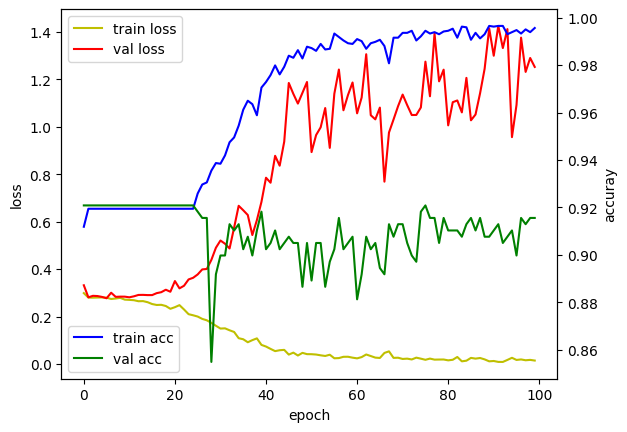

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [10]:
loaded_model = load_model(f'{nowDatetime} CNN{str(epochs)}.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

12/12 [==============================] - 2s 126ms/step - loss: 1.2528 - accuracy: 0.9156
n validation_Accuracy:  0.9155672788619995
confusion matrix
[[375   0]
 [  0   4]]


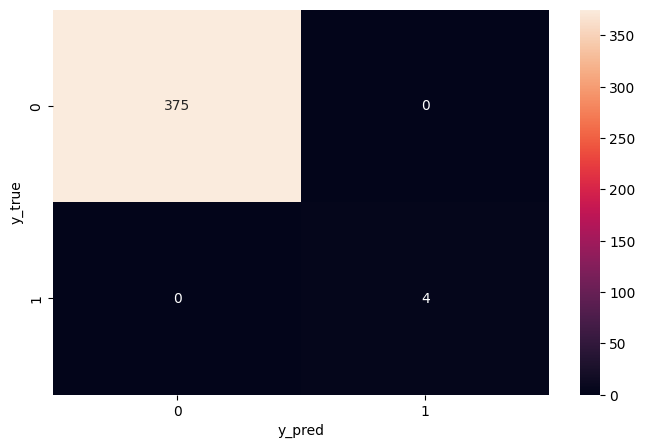

In [11]:
accuracy = loaded_model.evaluate(validation_generator)
print('n', 'validation_Accuracy: ', accuracy[1])
pred = loaded_model.predict(validation_generator)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

180/180 [==============================] - 25s 141ms/step - loss: 15.0089 - accuracy: 0.9864
n Test_Accuracy:  0.9863921999931335
confusion matrix
[[5654    0]
 [   0   78]]


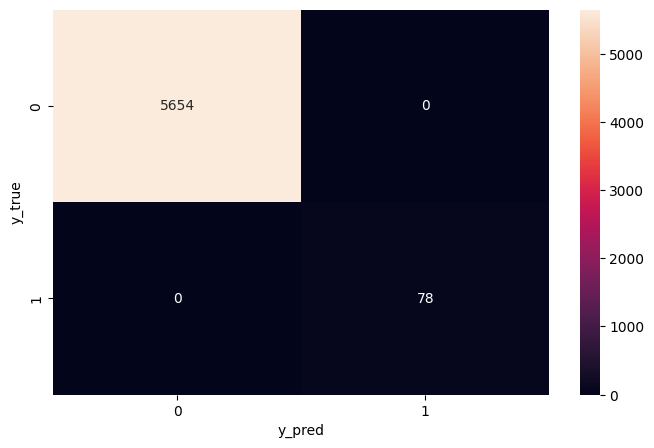

In [12]:
accuracy = loaded_model.evaluate(test_generator)
print('n', 'Test_Accuracy: ', accuracy[1])
pred = loaded_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [15]:
submission_csv_path = 'open/sample_submission.csv'

submission = pd.read_csv(submission_csv_path)
submission['covid19'] = y_pred
submission = submission.set_index('id', drop=True)
submission

,covid19
id,
3806,0
3807,0
3808,0
3809,0
3810,0
...,...
9533,0
9534,0
9535,0


In [ ]:
# 확진 예측한 spectrogram확인
confirmed = list(submission.loc[submission['covid19'] == 1].index)

for i in confirmed:
    img_color = plt.imread(f'./mel/test/class/0{i}.png')
    plt.imshow(img_color)
    plt.show()

In [16]:
submission.to_csv(f'submission_epochs_{epochs}.csv')